In [1]:
import re
import pandas as pd
from collections import defaultdict

# sumy
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals
 
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.edmundson import EdmundsonSummarizer

# NLTK stopwords
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

In [2]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [53]:
pattern = ("(C H A P T E R [A-Z -]+)\n+" +           # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=C H A P T E R|This book)")            # chapter contents ends with a new chapter or the end of book
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read().replace('&rsquo;',"'")
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&ldquo;', '"')
                                   .replace('&rdquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\n+', '\n', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)

### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [4]:
stop_words = stopwords.words('english')

In [5]:
# Convert to list
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
data_words = list(sent_to_words(data))

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path

In [13]:
def compute_coherence_values(dictionary, corpus, texts, stop, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
# Can take a long time to run.
start=5; stop=35; step=1;
stop += 1
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        stop=stop,
                                                        step=step)

Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model
Calculating 35-topic model


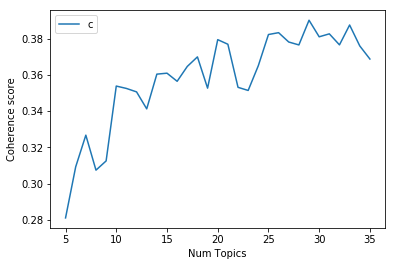

In [18]:
# Show graph
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
idx = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6), '  Model index', idx)
    idx += 1un.compu

Num Topics = 5  has Coherence Value of 0.281098   Model index 0
Num Topics = 6  has Coherence Value of 0.309259   Model index 1
Num Topics = 7  has Coherence Value of 0.326732   Model index 2
Num Topics = 8  has Coherence Value of 0.307438   Model index 3
Num Topics = 9  has Coherence Value of 0.312527   Model index 4
Num Topics = 10  has Coherence Value of 0.35381   Model index 5
Num Topics = 11  has Coherence Value of 0.352498   Model index 6
Num Topics = 12  has Coherence Value of 0.350596   Model index 7
Num Topics = 13  has Coherence Value of 0.341241   Model index 8
Num Topics = 14  has Coherence Value of 0.360384   Model index 9
Num Topics = 15  has Coherence Value of 0.360909   Model index 10
Num Topics = 16  has Coherence Value of 0.356438   Model index 11
Num Topics = 17  has Coherence Value of 0.364632   Model index 12
Num Topics = 18  has Coherence Value of 0.369899   Model index 13
Num Topics = 19  has Coherence Value of 0.352655   Model index 14
Num Topics = 20  has Coher

In [27]:
# Select the model and print the topics
index = 15
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(formatted=False)

In [28]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [29]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_number', 'dominant_topic', 'topic_percent_contribution', 'keywords', 'text']

In [47]:
bonus_words = [text.split(', ') for text in df_dominant_topic['keywords'].tolist()]

In [51]:
len(bonus_words)

192

In [31]:
def summarize(text, sentence_count, bonus_words, language='english'):
    summarizer = EdmundsonSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)
    summarizer.bonus_words = bonus_words
    summarizer.stigma_words = ['zdfgthdvndadv']
    summarizer.null_words = stopwords.words('english')
    summary = summarizer(PlaintextParser(text, Tokenizer(language)).document, sentence_count)
    return summary

In [32]:
def print_summary(summary):
    for sentence in summary:
        print(sentence)

In [46]:
doc = 0
for book in hp:
    print(book)
    for chapter in hp[book]:
        print('{} - {}'.format(chapter, hp[book][chapter][0]))
        words = bonus_words[doc]
        # split up bigrams used in LDA model
        words = [item for sublist in [item.split('_') for item in words] for item in sublist]
        words.extend(hp[book][chapter][0].lower().split())
        print_summary(summarize(hp[book][chapter][1], 5, words))
        doc += 1
        print()
    print()

Harry Potter and the Sorcerer's Stone
Chapter 1 - THE BOY WHO LIVED
At half past eight, Mr. Dursley picked up his briefcase, pecked Mrs. Dursley on the cheek, and tried to kiss Dudley good-bye but missed, because Dudley was now having a tantrum and throwing his cereal at the walls.
When Dudley had been put to bed, he went into the living room in time to catch the last report on the evening news: "And finally, bird-watchers everywhere have reported that the nation's owls have been behaving very unusually today.
Twelve times he clicked the Put-Outer, until the only lights left on the whole street were two tiny pinpricks in the distance, which were the eyes of the cat watching him.
One small hand closed on the letter beside him and he slept on, not knowing he was special, not knowing he was famous, not knowing he would be woken in a few hours' time by Mrs. Dursley's scream as she opened the front door to put out the milk bottles, nor that he would spend the next few weeks being prodded an

At three-thirty that afternoon, Harry, Ron, and the other Gryffindors hurried down the front steps onto the grounds for their first flying lesson.
Harry saw his scared white face look down at the ground falling away, saw him gasp, slip sideways off the broom and — WHAM — a thud and a nasty crack and Neville lay facedown on the grass in a heap.
All the same, it wasn't what you'd call the perfect end to the day, Harry thought, as he lay awake much later listening to Dean and Seamus falling asleep (Neville wasn't back from the hospital wing).
Harry yelled, and the four of them sprinted down the gallery, not looking back to see whether Filch was following — they swung around the doorpost and galloped down one corridor then another, Harry in the lead, without any idea where they were or where they were going — they ripped through a tapestry and found themselves in a hidden passageway, hurtled along it and came out near their Charms classroom, which they knew was miles from the trophy room.


and look comforting at the same time, ushered Dobby back onto the bed where he sat hiccoughing, looking like a large and very ugly doll.
But Dobby has come to protect Harry Potter, to warn him, even if he does have to shut his ears in the oven door later.
hissed Harry, stuffing Dobby in, shutting the door, and flinging himself onto the bed just as the door handle turned.
Before Harry could move, Dobby had darted to the bedroom door, pulled it open, and sprinted down the stairs.
He saw Dobby's face in the crowd and shouted out, asking for help, but Dobby called, "Harry Potter is safe there, sir!"

Chapter 3 - THE BURROW
"If the Dursleys wake up, I'm dead," said Harry as he tied the rope tightly around a bar and Fred revved up the car.
The car revved louder and louder and suddenly, with a crunching noise, the bars were pulled clean out of the window as Fred drove straight up in the air.
"One good push —" Harry and George threw their shoulders against the trunk and it slid out of the wind

The news that Colin Creevey had been attacked and was now lying as though dead in the hospital wing had spread through the entire school by Monday morning.
In the second week of December Professor McGonagall came around as usual, collecting names of those who would be staying at school for Christmas.
Snape prowled through the fumes, making waspish remarks about the Gryffindors' work while the Slytherins sniggered appreciatively.
"Dear, dear," said Lockhart, skittering through the crowd, looking at the aftermath of the duels.
By next morning, however, the snow that had begun in the night had turned into a blizzard so thick that the last Herbology lesson of the term was canceled: Professor Sprout wanted to fit socks and scarves on the Mandrakes, a tricky operation she would entrust to no one else, now that it was so important for the Mandrakes to grow quickly and revive Mrs. Norris and Colin Creevey.

Chapter 12 - THE POLYJUICE POTION
In the shock of Fawkes catching fire, Harry had forgo

Far from wishing Harry a happy birthday, none of the Dursleys made any sign that they had noticed Harry enter the room, but Harry was far too used to this to care.
Even though she was not a blood relative of Harry's (whose mother had been Aunt Petunia's sister), he had been forced to call her "Aunt" all his life.
At Dudley's fifth birthday party, Aunt Marge had whacked Harry around the shins with her walking stick to stop him from beating Dudley at musical statues.
Harry knew perfectly well that Dudley only put up with Aunt Marge's hugs because he was well paid for it, and sure enough, when they broke apart, Dudley had a crisp twenty-pound note clutched in his fat fist.AUNT MARGE'S
Aunt Marge and Aunt Petunia kissed, or rather, Aunt Marge bumped her large jaw against Aunt Petunia's bony cheekbone.

Chapter 3 - THE KNIGHT BUS
There was a little wizard gold in the money bag at the bottom of his trunk, but the rest of the fortune his parents had left him was stored in a vault at Gringotts

I chose a very inconvenient time to fall ill." What with the promise of anti-dementor lessons from Lupin, the thought that he might never have to hear his mother's death again, and the fact that Ravenclaw flattened Hufflepuff in their Quid-ditch match at the end of November, Harry's mood took a definite upturn.
They joined each other, they crisscrossed, they fanned into every corner of the parchment; then words began to blossom across the top, great, curly green words, that proclaimed: Messrs. Moony, Wormtail, Padfoot, and Prongs Purveyors of Aids to Magical Mischief-Makers are proud to present THE MARAUDER'S MAP It was a map showing every detail of the Hogwarts castle and grounds.
A labeled dot in the top left corner showed that Professor Dumbledore was pacing his study; the caretaker's cat, Mrs. Norris, was prowling the second floor; and Peeves the Poltergeist was currently bouncing around the trophy room.
"Of all the people to go over to the Dark Side, Sirius Black was the last I'd 

"I found this at the base of the Whomping Willow," said Snape, throwing the cloak aside, careful to keep this wand pointing directly at Lupin's chest.
"If Voldemort's supporters were after me, it was because I put one of their best men in Azkaban — the spy, Sirius Black!"
It must have been the finest moment of your miserable life, telling Voldemort you could hand him the Potters."
If he gave them Harry, who'd dare say he'd betrayed Lord Voldemort?
Crookshanks leapt lightly off the bed and led the way out of the room, his bottlebrush tail held jauntily high.

Chapter 20 - THE DEMENTOR'S KISS
The difference it made was startling, as though a person ten years younger were shining through the starved mask; for a moment, he was recognizable as the man who had laughed at Harry's parents' wedding.
The grounds were very dark now; the only light came from the distant windows of the castle.
As the werewolf wrenched itself free of the manacle binding it, the dog seized it about the neck and pulle

The tiny kitchen exploded with laughter; Harry looked around and saw that Ron and George were sitting at the scrubbed wooden table with two red-haired people Harry had never seen before, though he knew immediately who they must be: Bill and Charlie, the two eldest Weasley brothers.
Harry knew that he worked for the wizarding bank, Gringotts, and that Bill had been Head Boy at Hogwarts; Harry had always imagined Bill to be an older version of Percy: fussy about rule-breaking and fond of bossing everyone around.
"If it's got anything to do with Weasleys' Wizard Wheezes —" "Why don't you show Harry where he's sleeping, Ron?"
"What are Weasleys' Wizard Wheezes?"
By seven o'clock, the two tables were groaning under dishes and dishes of Mrs. Weasley's excellent cooking, and the nine Weasleys,WEASLEYS' WIZARD

Chapter 6 - THE PORTKEY
Mrs. Weasley was stirring the contents of a large pot on the stove, while Mr. Weasley was sitting at the table, checking a sheaf of large parchment tickets.
"Yes

Professor Trelawney kept predicting Harry's death, which he found extremely annoying.
His preoccupation lasted all the way across the sodden vegetable patch until they arrived in greenhouse three, but here he was distracted by Professor Sprout showing the class the ugliest plants Harry had ever seen.
When the bell rang to signal the start of afternoon lessons, Harry and Ron set off for North Tower where, at the top of a tightly spiraling staircase, a silver stepladder led to a circular trapdoor in the ceiling, and the room where Professor Trelawney lived.
"Good day," said the misty voice of Professor Trelawney right behind Harry, making him jump.
It seems as though the Ministry of Magic's troubles are not yet at an end, writes Rita Skeeter, Special Correspondent.

Chapter 14 - THE UNFORGIVABLE CURSES
"Years back, there were a lot of witches and wizards being controlled by the Imperius Curse," said Moody, and Harry knew he was talking about the days in which Voldemort had been all-power

Drafty though the castle always was in winter, Harry was glad of its fires and thick walls every time he passed the Durmstrang ship on the lake, which was pitching in the high winds, its black sails billowingCHAPTER TWENTY-ONE against the dark skies.
"What are we now, then, the House-Elf Liberation Front?
She seized his arm again, pulled him in front of the picture of the giant fruit bowl, stretched out her forefinger, and tickled the huge green pear.
He had one brief glimpse of an enormous, high-ceilinged room, large as the Great Hall above it, with mounds of glittering brass pots and pans heaped around the stone walls, and a great brick fireplace at the other end, when something small hurtled toward him from the middle of the room, squealing, "Harry Potter, sir!
You see, sir, it is very difficult for a house-elf who has been dismissed to get a new position, sir, very difficult indeed —"CHAPTER TWENTY-ONE At this, Winky howled even harder, her squashed-tomato of a nose dribbling all d

When they had set off into the dusk, looking extremely odd carrying the large package between them, Harry leaned on the windowsill, looking out at the grounds, at the dark, rustling treetops of the Forbidden Forest, and the rippling sails ofCHAPTER TWENTY-EIGHT the Durmstrang ship.
The bell rang across the grounds for lunch; the rest of the class set off back to the castle, but Harry, Ron, and Hermione stayed behind to help Hagrid put the nifflers back in their boxes.
The Wronski Feint, you really —" But something moved behind Krum in the trees, and Harry, who had some experience of the sort of thing that lurked in the forest, instinctively grabbed Krum's arm and pulled him around.
Crouch was now talking fluently to a tree again, and seemedCHAPTER TWENTY-EIGHT completely unaware that Harry was there, which surprised Harry so much he didn't notice that Crouch had released him.
"Krum and I were talking, Mr. Bagman had just finished telling us about the third task, we stayed behind, and t

As he spoke, visions of everything that had passed that night seemed to rise before his eyes; he saw the sparkling surface of the potion that had revived Voldemort; he saw the Death Eaters Apparating between the graves around them; he saw Cedric's body, lying on the ground beside the cup.
Harry described how the figures that had emerged from the wand had prowled the edges of the golden web, how Voldemort had seemed to fear them, how the shadow of Harry's father had told him what to do, how Cedric's had made its final request.
Everything around him became hazy; the lamps around the hospital wing seemed to be winking at him in a friendly way through the screen around his bed; his body felt as though it was sinking deeper into the warmth of the feather matress.
For heaven's sake, Dumbledore — the boy was full of some crackpot story at the end of last year too — his tales are getting taller, and you're still swallowing them — the boy can talk to snakes, Dumbledore, and you still think he's

Glittering jets of water were flying from the ends of the two wands, the point of the centaur's arrow, the tip of the goblin's hat, and each of the house-elf's ears, so that the tinkling hiss of falling water was added to the pops and cracks of Apparators and the clatter of footsteps as hundreds of witches and wizards, most of whom were wearing glum, early-morning looks, strode toward a set of golden gates at the far end of the hall.
The lift doors opened; Harry glimpsed an untidy-looking corridor, with various posters of Quidditch teams tacked lopsidedly on the walls; one of the wizards in the lift, who was carrying an armful of broomsticks, extricated himself with difficulty and disappeared down the corridor.
The doors closed, the lift juddered upward again, and the woman's voice said, "Level six, Department of Magical Transport, incorporating the Floo Network Authority, Broom Regulatory Control, Portkey Office, and Apparation Test Center."
"Level five, Department of International Ma

There was a moment's pause in which Filch glared at Cho and Cho  glared right back, then the caretaker turned and shuffled back toward the door.
Sturgis Podmore, 38, of number two, Laburnum Gardens, Clapham, has appeared in front of the Wizengamot charged with trespass and attempted robbery at the Ministry of Magic on 31st August.
"The Ministry suspects he's one of Dumbledore's lot so — I dunno — they lured him to the Ministry, and he wasn't trying to get through a door at all!
Something in her would-be casual voice made Harry think he might know who the uninvited spectators were, and sure enough, when they left the changing room for the bright sunlight of the pitch it was to a storm of catcalls and jeers from the Slytherin Quidditch team and assorted hangers-on, who were grouped halfway up the empty stands and whose voices echoed loudly around the stadium.
When Angelina blew her whistle, Harry released the Snitch and Fred and George let fly the Bludger; from that moment on, Harry was 

"Everard and Dilys were two of Hogwarts's most celebrated Heads," Dumbledore said, now sweeping around Harry, Ron, and Professor McGonagall and approaching the magnificent sleeping bird on his perch beside the door.
He doesn't look good, he's covered in blood, I ran along to Elfrida Cragg's portrait to get a good view as they left —" "Good," said Dumbledore as Ron made a convulsive movement, "I take it Dilys will have seen him arrive, then —" And moments later, the silver-ringletted witch had reappeared in her picture too; she sank, coughing, into her armchair and said, "Yes, they've taken him to St. Mungo's, Dumbledore.
"He has been taken to St. Mungo's Hospital for Magical Maladies and Injuries.
Everybody except Harry was riotously happy and talkative as they changed out of their robes into jeans and sweatshirts, and they greeted Tonks and Mad-Eye, who had turned up to escort them across London, gleefully laughing at the bowler hat Mad-Eye was wearing at anCHAPTER TWENTY-TWO angle to

"Yeh — yeh'll see in a mo'," said Hagrid, looking over his shoulder as a great roar rose from the stands behind them.
When they reached his cabin, Hermione turned automatically left toward the front door; Hagrid, however, walked straight past it into the shade of the trees on the outermost edge of the forest, where he picked up a crossbow that was leaning against a tree.
They were soon a long way past the clearing where Hagrid had shown them the thestrals, but Harry felt no sense of unease until Hagrid stepped unexpectedly off the path and began wending his way in and out of trees toward the dark heart of the forest.
Yeh've met him an' — an' now he'll know yeh when yeh come back.
"If yeh say so," said Hagrid, shrugging, "but personally I think yeh're makin' a big mistake —" "As are you, human," said Bane, "coming back into our forest when we warned you —" "Now, you listen ter me," said Hagrid angrily.

Chapter 30 - O.W.L.S
The purposeful, feverish atmosphere drove nearly everything but

"I cared more for your happiness than your knowing the truth, more for your peace of mind than my plan, more for your life than the lives that might be lost if the plan failed.
"It meant," said Dumbledore, "that the person who has the only chance of conquering Lord Voldemort for good was born at the end of July, nearly sixteen years ago.
"But you said — Neville was born at the end of July too — and his mum and dad —" "You are forgetting the next part of the prophecy, the final identifying feature of the boy who could vanquish Voldemort.
"He heard only the first part, the part foretelling the birth of a boy in July to parents who had thrice defied Voldemort.
He did not know that you would have &lsquo;power the Dark Lord knows not' —" "But I don't!"


Harry Potter and the Half-Blood Prince
Chapter 1 - THE OTHER MINISTER
When several carpenters, a builder or two, an art historian, and the Chancellor of the Exchequer had all tried unsuccessfully to prise it from the wall, the Prime Ministe

Harry had never hated Malfoy more than as he lay there, like an absurd turtle on its back, blood dripping sickeningly into his open mouth.
There was a flash of red light and Harry's body unfroze; he was able to push himself into a more dignified sitting position, hastily wipe the blood off his bruised face with the back of his hand, and raise his head to look up at Tonks, who was holding the Invisibility Cloak she had just pulled away.
And incidentally," said Snape, standing back to allow Harry to pass him, "I was interested to see your new Patronus."
They reached the castle steps at last and as the great oaken front doors swung open into the vast flagged entrance hall, a burst of talk and laughter and of tinkling plates and glasses greeted them through the doors standing open into the Great Hall.
Harry turned on the spot and marched straight through the open doors: anything to get away from Snape.

Chapter 9 - THE HALF-BLOOD PRINCE
"He and Professor Trelawney are dividing classes betw

"Then, as Charlie isn't coming home, that just leaves Harry and Ron in the attic, and if Fleur shares with Ginny —" "— that'll make Ginny's Christmas —" muttered Fred.
Harry did not get the chance to speak to Mr. Weasley, who was working very long hours at the Ministry, until Christmas Eve night.
Fred, George, Harry, and Ron were the only ones who knew that the angel on top of the tree was actually a garden gnome that had bitten Fred on the ankle as he pulled up carrots for Christmas dinner.
Harry's presents included a sweater with a large Golden Snitch worked onto the front, hand-knitted by Mrs. Weasley, a large box of Weasleys' Wizard Wheezes products from the twins, and aA VERY FROSTY
Everybody was wearing new sweaters when they all sat down for Christmas lunch, everyone except Fleur (on whom, it appeared, Mrs. Weasley had not wanted to waste one) and Mrs. Weasley herself, who was sporting a brand-new midnight blue witch's hat glittering with what looked like tiny starlike diamonds,

But Harry was already hurtling back along the corridor and within minutes, he was saying "toffee &eacute;clairs" to Dumbledore's gargoyle, which leapt aside, permitting Harry entrance onto the spiral staircase.
Dumbledore landed beside Harry just as Riddle asked, "Sir, is it true that Professor Merrythought is retiring?"
Harry sat in thought for a moment, then asked, "So if all of his Horcruxes are destroyed, Voldemort could be killed?"
"But," said Harry, bewildered, "but last year, you said one of us would have to kill the other —" "Harry, Harry, only because Voldemort made a grave error, and acted on Professor Trelawney's words!
It is Voldemort's fault that you were able to see into his thoughts, his ambitions, that you even understand the snakelike language in which he gives orders, and yet, Harry, despite your privileged insight into Voldemort's world (which, incidentally, is a gift any Death Eater would kill to have), you have never been seduced by the Dark Arts, never, even for a

Pushing open the doors, Harry saw Neville lying, apparently asleep, in a bed near the door.
How long they all stood there, listening, he did not know, nor why it seemed to ease their pain a little to listen to the sound of their mourning, but it felt like a long time later that the hospital door opened again and Professor McGonagall entered the ward.
The doors of the hospital wing burst open, making them all jump: Mr. and Mrs. Weasley were striding up the ward, Fleur just behind them, her beautiful face terrified.
When the Chamber of Secrets reopened he considered the closure of the school — and I must say that Professor Dumbledore's murder is more disturbing to me than the idea of Slytherin's monster living undetected in the bowels of the castle.
"Very well," said Professor McGonagall, glancing out of the window at the grounds, checking to see whether the Minister was yet approaching, "then I must agree with Filius that the right thing to do is to consult the governors, who will make 

There was a large poster of the Wizarding band the Weird Sisters on one wall, and a picture of Gwenog Jones, Captain of the all-witch Quid-ditch team the Holyhead Harpies, on the other.
"There's the silver lining I've been looking for," she whispered, and then she was kissing him as she had never kissed him before, and Harry was kissing her back, and it was blissful oblivion, better than firewhisky; she was the only real thing in the world, Ginny, the feel of her, one hand at her back and one in her long, sweet-smelling hair — The door banged open behind them and they jumped apart.
"The Decree for Justifiable Confiscation gives the Ministry the power to confiscate the contents of a will —" "That law was created to stop wizards passing on Dark artifacts," said Hermione, "and the Ministry is supposed to have powerful evidence that the deceased's possessions are illegal before seizing them!
"&lsquo;The Last Will and Testament of Albus Percival Wulfric Brian Dumbledore' .
Everyone exclaime

However, in the few moments it took for Ron to give a low groan and Harry to start crawling toward him, he realized that this was not the Forbidden Forest: The trees looked younger, they were more widely spaced, the ground clearer.
The moment his eyes fell upon Ron, all other concerns fled Harry's mind, for blood drenched the whole of Ron's left side and his face stood out, grayish-white, against the leaf-strewn earth.
she added, pointing her wand at the misshapen canvas, which in one fluid motion rose into the air and settled, fully constructed, onto the ground before Harry, out of whose startled hands a tent peg soared, to land with a final thud at the end of a guy rope.
With the Sneakoscope Hermione had given Harry for his birthday set carefully upon the table in the tent, Harry and Hermione spent the rest of the day sharing the role of lookout.
The hanging man's pupils were wide, dilated with fear, and they seemed to swell, bigger and bigger until their blackness swallowed Harry wh

His Cloak was the third Hallow, and when he discovered how to open the Snitch he would have the second, and then all he needed to do was find the first Hallow, the Elder Wand, and then — But it was as though a curtain fell on a lit stage: All his excitement, all his hope and happiness were extinguished at a stroke, and he stood alone in the darkness, and the glorious spell was broken.
Please," she said as he started to speak, "please just answer me this: If the Deathly Hallows really existed, and Dumbledore knew about them, knew that the person who possessed all three of them would be master of Death — Harry, why wouldn't he have told you?
The idea of the Deathly Hallows had taken possession of him, and he could not rest while agitating thoughts whirled through his mind: the wand, the stone, and the Cloak, if he could just possess them all.
Roused for the first time in days from his contemplation of the Deathly Hallows, Harry hurried back inside the tent to find Ron and Hermione kneeli

Of course, something will have to be done about Professor Snape —" "Let me —" "— and if Hogwarts is about to enter a state of siege, with the Dark Lord at the gates, it would indeed be advisable to take as many innocent people out of the way as possible.
Along the corridors they raced, and one by one the Patronuses left them; Professor McGonagall's tartan dressing gown rustled over the floor, and Harry and Luna jogged behind her under the Cloak.THE SACKING OF
Hatred boiled up in Harry at the sight of him: He had forgotten the details of Snape's appearance in the magnitude of his crimes, forgotten how his greasy black hair hung in curtains around his thin face, how his black eyes had a dead, cold look.
She brandished her wand at a torch on the wall and it flew out of its bracket: Harry, about to curse Snape, was forced to pull Luna out of the way of the descending flames, which became a ring of fire that filled the corridor and flew like a lasso at Snape — Then it was no longer fire, bu